In [ ]:
!wget https://ivg.au.tsinghua.edu.cn/dataset/samples_THUPALMLAB/THUPALMLAB.rar


--2025-03-16 01:25:15--  https://ivg.au.tsinghua.edu.cn/dataset/samples_THUPALMLAB/THUPALMLAB.rar
Resolving ivg.au.tsinghua.edu.cn (ivg.au.tsinghua.edu.cn)... 101.6.15.70, 2402:f000:1:402:101:6:15:70
Connecting to ivg.au.tsinghua.edu.cn (ivg.au.tsinghua.edu.cn)|101.6.15.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3535915674 (3.3G) [application/x-rar-compressed]
Saving to: ‘THUPALMLAB.rar’

THUPALMLAB.rar      100%[===================>]   3.29G  8.03MB/s    in 7m 28s  

2025-03-16 01:32:45 (7.52 MB/s) - ‘THUPALMLAB.rar’ saved [3535915674/3535915674]



In [ ]:
!unrar x THUPALMLAB.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from THUPALMLAB.rar

Creating    image                                                     OK
Extracting  image/10_l_1.bmp                                             0  OK 
Extracting  image/10_l_2.bmp                                             0  OK 
Extracting  image/10_l_3.bmp                                             0  OK 
Extracting  image/10_l_4.bmp                                             0  OK 
Extracting  image/10_l_5.bmp                                             0  OK 
Extracting  image/10_l_6.bmp                                             0  OK 
Extracting  image/10_l_7.bmp                                             0  OK 
Extracting  image/10_l_8.bmp                                             0  OK 
Extracting  image/10_r_1.bmp                                             0  OK 
Extracting  image/10_r_2.bmp                                             0  OK 
Extracting  image/1

In [ ]:
# !rm THUPALMLAB.rar

In [ ]:
import os
import glob
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict
import keras


In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [ ]:
image_paths = glob.glob("image/**/*.bmp", recursive=True)
print("Total images found:", len(image_paths))

def extract_label(path):
    basename = os.path.basename(path)
    label = basename.split('_')[0] + '_' + basename.split('_')[1]
    return label

labels = [extract_label(p) for p in image_paths]
print("Sample labels:", labels[:5])

Total images found: 1280
Sample labels: ['17_r', '24_r', '66_l', '21_l', '54_r']


In [ ]:
np.unique(labels)

array(['10_l', '10_r', '11_l', '11_r', '12_l', '12_r', '13_l', '13_r',
       '141_l', '141_r', '14_l', '14_r', '150_l', '150_r', '151_l',
       '151_r', '152_l', '152_r', '153_l', '153_r', '154_l', '154_r',
       '155_l', '155_r', '156_l', '156_r', '157_l', '157_r', '158_l',
       '158_r', '159_l', '159_r', '15_l', '15_r', '160_l', '160_r',
       '16_l', '16_r', '17_l', '17_r', '18_l', '18_r', '19_l', '19_r',
       '1_l', '1_r', '20_l', '20_r', '21_l', '21_r', '22_l', '22_r',
       '23_l', '23_r', '24_l', '24_r', '25_l', '25_r', '26_l', '26_r',
       '27_l', '27_r', '28_l', '28_r', '29_l', '29_r', '2_l', '2_r',
       '30_l', '30_r', '31_l', '31_r', '33_l', '33_r', '34_l', '34_r',
       '35_l', '35_r', '36_l', '36_r', '37_l', '37_r', '38_l', '38_r',
       '39_l', '39_r', '3_l', '3_r', '40_l', '40_r', '41_l', '41_r',
       '42_l', '42_r', '43_l', '43_r', '44_l', '44_r', '45_l', '45_r',
       '46_l', '46_r', '47_l', '47_r', '48_l', '48_r', '49_l', '49_r',
       '4_l', '4_r',

Sample image shape: (224, 224, 1)


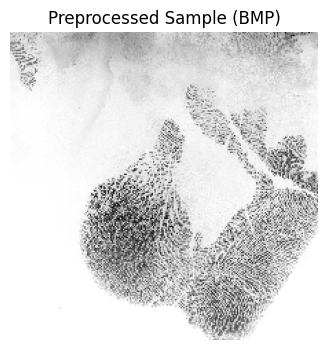

In [ ]:
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_bmp(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.image.rgb_to_grayscale(image)
    image = image / 255.0
    return image

sample_image = preprocess_image(image_paths[0])
print("Sample image shape:", sample_image.shape)

plt.figure(figsize=(4, 4))
plt.imshow(sample_image[..., 0], cmap='gray')
plt.title("Preprocessed Sample (BMP)")
plt.axis("off")
plt.show()

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
dataset = dataset.map(lambda path, label: (preprocess_image(path), label),
                      num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
dataset_sample = dataset.shuffle(buffer_size=len(image_paths), reshuffle_each_iteration=False)

sample_list = list(dataset_sample.as_numpy_iterator())
print("Number of sampled images:", len(sample_list))

Number of sampled images: 1280


In [ ]:
subject_dict = defaultdict(list)
for image, label in sample_list:
    subject_dict[label].append(image)

positive_pairs = []
for label, images in subject_dict.items():
    if len(images) >= 2:
        for i in range(len(images)):
            for j in range(i+1, len(images)):
                positive_pairs.append((images[i], images[j], 1))
print("Positive pairs generated:", len(positive_pairs))

negative_pairs = []
all_labels = list(subject_dict.keys())

while len(negative_pairs) < len(positive_pairs):
    label1, label2 = random.sample(all_labels, 2)
    if subject_dict[label1] and subject_dict[label2]:
        image1 = random.choice(subject_dict[label1])
        image2 = random.choice(subject_dict[label2])
        negative_pairs.append((image1, image2, 0))
print("Negative pairs generated:", len(negative_pairs))

all_pairs = positive_pairs + negative_pairs
random.shuffle(all_pairs)

left_images = [pair[0] for pair in all_pairs]
right_images = [pair[1] for pair in all_pairs]
labels = [pair[2] for pair in all_pairs]

Positive pairs generated: 4480
Negative pairs generated: 4480


In [ ]:
split_index = int(0.8 * len(all_pairs))
train_pairs = all_pairs[:split_index]
test_pairs = all_pairs[split_index:]
print("Training pairs:", len(train_pairs))
print("Testing pairs:", len(test_pairs))

Training pairs: 7168
Testing pairs: 1792


In [ ]:
left_images_train = [pair[0] for pair in train_pairs]
right_images_train = [pair[1] for pair in train_pairs]
labels_train = [pair[2] for pair in train_pairs]

In [ ]:
left_images_test = [pair[0] for pair in test_pairs]
right_images_test = [pair[1] for pair in test_pairs]
labels_test = [pair[2] for pair in test_pairs]

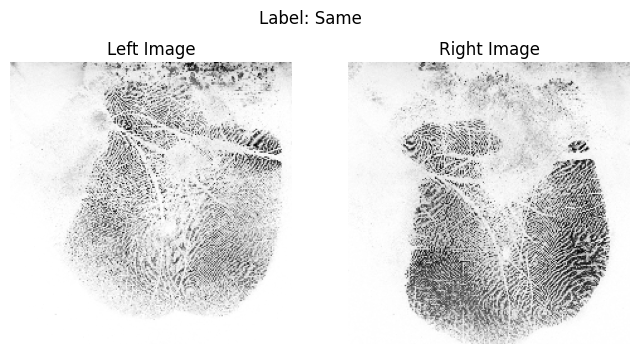

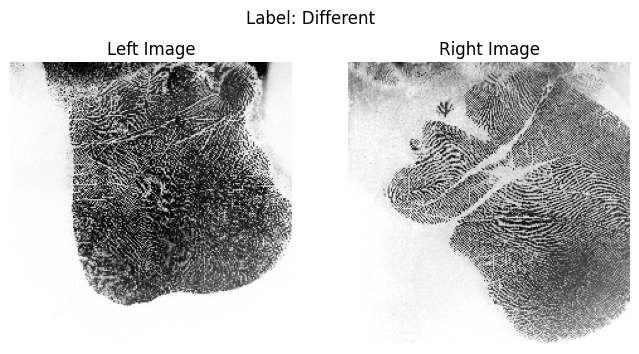

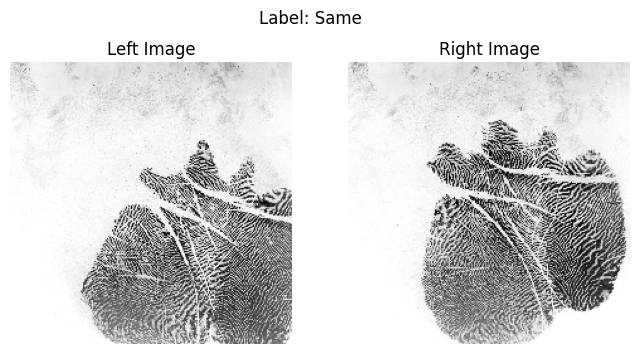

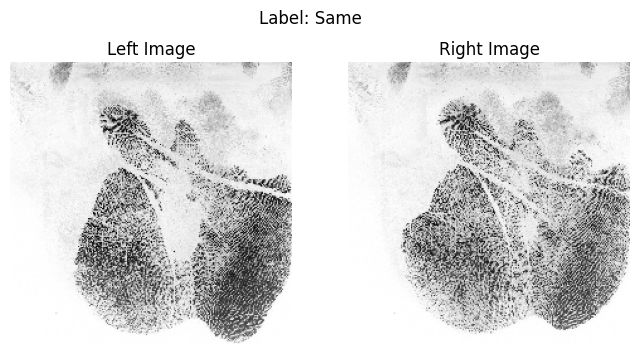

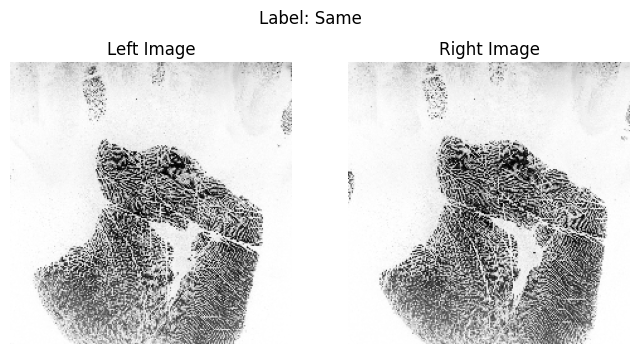

In [ ]:
def display_pair(pair):
    left, right, label = pair
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(left[...,0], cmap='gray')
    axes[0].set_title("Left Image")
    axes[0].axis('off')
    axes[1].imshow(right[...,0], cmap='gray')
    axes[1].set_title("Right Image")
    axes[1].axis('off')
    plt.suptitle("Label: " + ("Same" if label == 1 else "Different"))
    plt.show()

for pair in train_pairs[:5]:
    display_pair(pair)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random
import keras

In [ ]:
def embedding_network(in_shape):
    input_layer = keras.layers.Input(in_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)

    return keras.Model(inputs=input_layer, outputs=x)

In [ ]:
# Define the energy function
@keras.saving.register_keras_serializable(name='euclidean_distance')
def euclidean_distance(vectors):
        vector1, vector2 = vectors
        sum_square = keras.ops.sum(keras.ops.square(vector1 - vector2), axis=1, keepdims=True)
        return keras.ops.sqrt(keras.ops.maximum(sum_square, keras.backend.epsilon()))

In [ ]:
def SiameseNetwork(in_shape):
    # 2.1. Define the twin networks using the embedding network
    input_1 = keras.layers.Input(in_shape)
    input_2 = keras.layers.Input(in_shape)

    # The siamese network shares weights between twin networks.
    #To allow this, we will use the same embedding network for both networks.
    embedding_net_obj = embedding_network(in_shape)

    twin_1 = (embedding_net_obj)(input_1)
    twin_2 = (embedding_net_obj)(input_2)

    # 2.2. Make sure the energy function has been defined

    # 2.3. Merge the twin networks using the energy function
    merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))([twin_1, twin_2])

    # 2.4. Normalize and send to sigmoid (optional step)
    norm_layer = keras.layers.BatchNormalization()(merge_layer)
    output_layer = keras.layers.Dense(1)(norm_layer)

    return keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [ ]:
@keras.saving.register_keras_serializable(name='custom_accuracy')
def custom_accuracy(y_true, y_pred):
    return keras.ops.mean(keras.ops.equal(y_true, keras.ops.cast(y_pred[:,0] < 0.5, "int32")))

In [ ]:
img_shape = (224, 224, 1)

In [ ]:
siamese_model = SiameseNetwork(img_shape)
siamese_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer="adam", metrics=['accuracy'])
siamese_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 224, 224, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ (None, 128)            │    102,868,096 │ input_layer[0][0],     │
│                           │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 1)              │              0 │ functional[0][0],      │
│                           │                        │                │ functional[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 1)              │              4 │ lambda[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │              2 │ batch_normalization[0… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 102,868,102 (392.41 MB)

 Trainable params: 102,868,100 (392.41 MB)

 Non-trainable params: 2 (8.00 B)

In [ ]:
left_images_train = np.array(left_images_train)
right_images_train = np.array(right_images_train)
labels_train = np.array(labels_train)
left_images_test = np.array(left_images_test)
right_images_test = np.array(right_images_test)
labels_test = np.array(labels_test)

In [ ]:
history = siamese_model.fit(
    [left_images_train, right_images_train],
    labels_train,
    epochs=5,
    validation_data=([left_images_test, right_images_test], labels_test)
)

Epoch 1/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 54s 190ms/step - accuracy: 0.8446 - loss: 0.4101 - val_accuracy: 0.9169 - val_loss: 0.2585
Epoch 2/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 41s 183ms/step - accuracy: 0.9564 - loss: 0.2362 - val_accuracy: 0.9754 - val_loss: 0.1785
Epoch 3/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 44s 196ms/step - accuracy: 0.9898 - loss: 0.1390 - val_accuracy: 0.9883 - val_loss: 0.1032
Epoch 4/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 42s 188ms/step - accuracy: 0.9977 - loss: 0.0833 - val_accuracy: 0.9916 - val_loss: 0.0747
Epoch 5/5
224/224 ━━━━━━━━━━━━━━━━━━━━ 43s 193ms/step - accuracy: 0.9977 - loss: 0.0565 - val_accuracy: 0.9939 - val_loss: 0.0585


In [ ]:
results = siamese_model.evaluate([left_images_test, right_images_test], labels_test)
print("test loss, test acc:", results)

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9942 - loss: 0.0564
test loss, test acc: [0.058455802500247955, 0.9938616156578064]


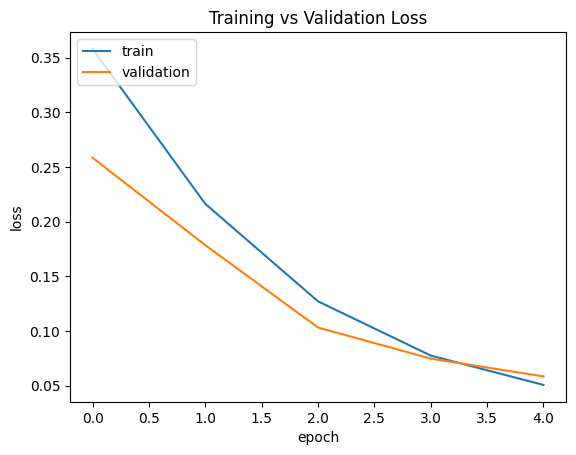

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["train", "validation"], loc="upper left")
plt.title("Training vs Validation Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step


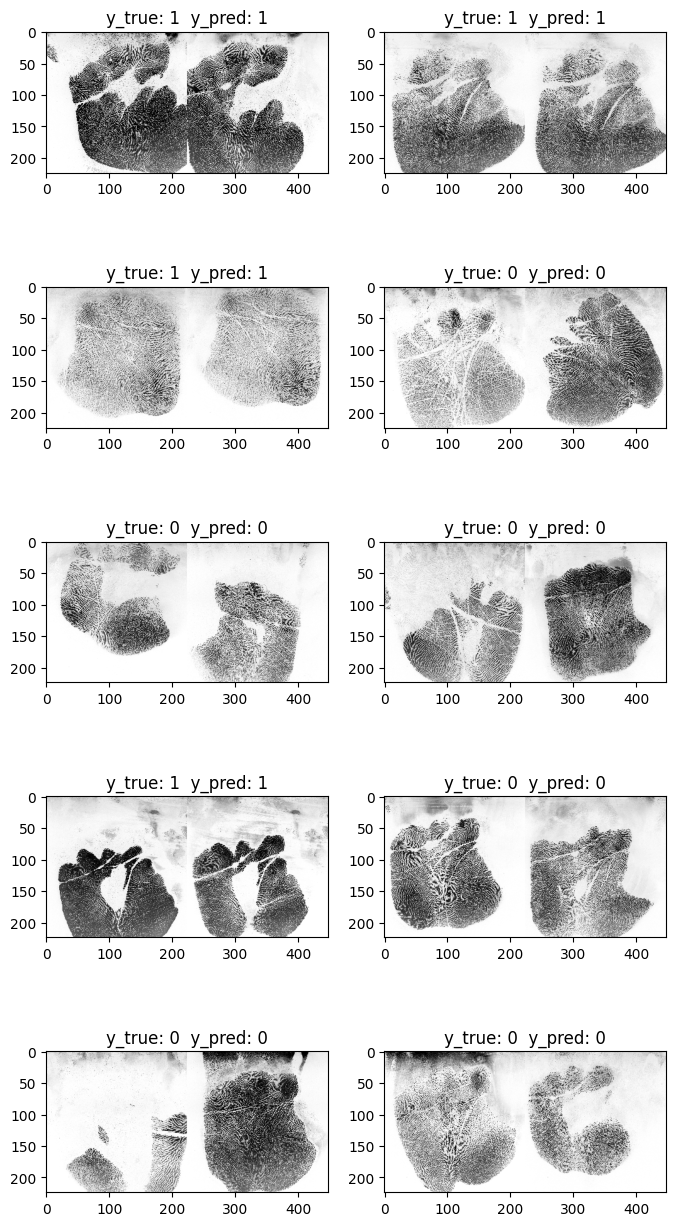

In [ ]:
predictions = siamese_model.predict([left_images_test, right_images_test])
y_pred_probs = tf.sigmoid(predictions).numpy()
y_pred_labels = (y_pred_probs > 0.5).astype(int).flatten()

fig, axes = plt.subplots(5, 2, figsize=(8, 16))
for i in range(10):
    ax = axes[i // 2, i % 2]
    img_idx = random.randint(0, len(labels_test) - 1)
    ax.imshow(tf.concat([left_images_test[img_idx], right_images_test[img_idx]], axis=1), cmap='gray')
    ax.set_title("y_true: {}  y_pred: {}".format(labels_test[img_idx], y_pred_labels[img_idx]))

In [ ]:
all_images = []
all_labels = []

for image, label in dataset_sample:
    all_images.append(image.numpy())
    all_labels.append(label.numpy().decode('utf-8'))

In [ ]:
def get_anchors(all_images, all_labels):
    anchors = []
    class_names = {}

    all_labels = np.array(all_labels)
    classes = np.unique(all_labels)

    for i in classes:
        class_images = np.where(all_labels == i)[0]
        anchors.append(all_images[random.choice(class_images)])
        class_names[i] = i

    return np.array(anchors), class_names

anchor_images, labels = get_anchors(all_images, all_labels)


In [ ]:
anchor_images, labels = get_anchors(all_images, all_labels)
anchors = list(zip(labels, anchor_images))

In [ ]:
def recognize_image(model, anchors, user_id, test_image):
    predictions = {}

    for label, anchor in anchors:
        pair = np.array([[anchor, test_image]])
        pred = model.predict([pair[:, 0], pair[:, 1]])
        pred_prob = tf.sigmoid(pred).numpy().flatten()[0]
        predictions[label] = pred_prob

    recognized_label = max(predictions, key=predictions.get)
    success = (recognized_label == user_id)

    recognized_anchor = next(anchor for lbl, anchor in anchors if lbl == recognized_label)

    return recognized_anchor, recognized_label, success



dataset_sample_list = list(dataset_sample.as_numpy_iterator())
random_index = random.randint(0, len(dataset_sample_list) - 1)
test_image, user_id = dataset_sample_list[random_index]
user_id = user_id.decode('utf-8')



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━

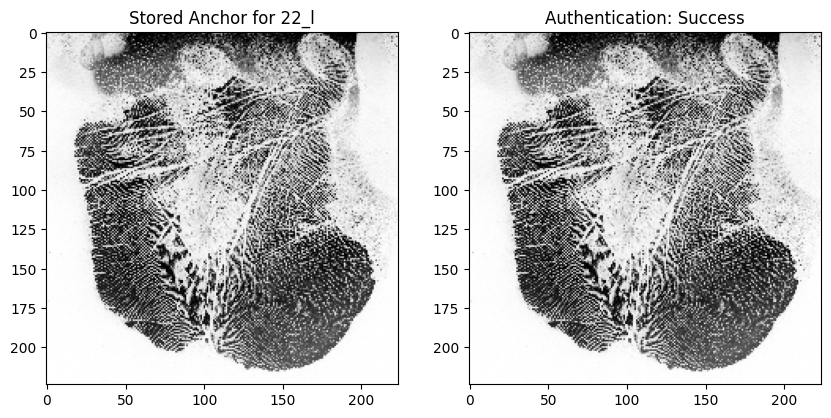

In [ ]:
matched_anchor, recognized_id, success = recognize_image(siamese_model, anchors, user_id, test_image)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(matched_anchor, cmap='gray')
ax[0].set_title(f"Stored Anchor for {recognized_id}")

ax[1].imshow(test_image, cmap='gray')
ax[1].set_title(f"Authentication: {'Success' if success else 'Failure'}")

plt.show()